## Vector Database

In [1]:
### Build Index
from langchain.document_loaders import CSVLoader
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:


# # Set embeddings
# embd = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# # Docs to index
# # urls = [

# #     "https://s2.q4cdn.com/661678649/files/doc_financials/2023/q3/fd2a8c99-afc6-4472-ae18-4f1ee024a274.pdf"

# # ]

# loader = CSVLoader(file_path='/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv')
# data = loader.load()


# #Load
# # docs = [WebBaseLoader(url).load() for url in urls]



# # docs_list = [item for sublist in docs for item in sublist]



# # Split
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=512, chunk_overlap=0
# )

# doc_splits = text_splitter.split_documents(data)

# # Add to vectorstore
# vectorstore = Chroma.from_documents(
#     documents=doc_splits,
#     embedding=embd,
# )



# retriever = vectorstore.as_retriever()

In [3]:
print(docs)

[[Document(metadata={'source': 'https://s2.q4cdn.com/661678649/files/doc_financials/2023/q3/fd2a8c99-afc6-4472-ae18-4f1ee024a274.pdf'}, page_content='%PDF-1.4\r\n%����\r\n1 0 obj\r\n<< /Producer <15ADD16D8165D47E42480C6345212D8DFD42FD68E1344EE6EDEE124031A4EEA71E6790>\r\n   /Creator <15ADD17EA321F4377D4410720C0A1CE0C64D9E42C06C7BF0FFAB52>\r\n   /Title <60D9A60FC1308067231A53271F6F789DBA5DEB1F>\r\n   /Author <15ADD17EA3AF92117F41177B496204E1C941FD4C8E696BE0F8A7441B7EE6B9B3412F8094B6C78CB763FCA19DFC7C7A062387DDD8>\r\n   /Subject <1686E452D1308273400D187C40272C8DE503FD1F9E282DAFBAFE0D402AB4A6FC5C69D4B387A4DC9F70E7A59CA86A34253886CF883E0CD8FF992E65B103B9>\r\n   /Keywords <60D9A60FC1308067231A53271F6F789DBA5DEB1F953A25A2BAFE0D23>\r\n   /CreationDate <14D3A40FC332836E23184F2719747A95A75DE90A9E2A39>\r\n   /ModDate <14D3A40FC332836E23184F2719747C9DA75DE90A9E2A39>\r\n>>\r\nendobj\r\n2 0 obj\r\n<< /Type /Catalog /Pages 3 0 R >>\r\nendobj\r\n3 0 obj\r\n<< /Type /Pages\r\n   /Kids [91 0 R 6 0 R 7 0

In [3]:
import os
import logging
from lightrag import LightRAG, QueryParam
from lightrag.llm import ollama_model_complete, ollama_embedding
from lightrag.utils import EmbeddingFunc

from langgraph.checkpoint.memory import MemorySaver

WORKING_DIR = "/nfs/kundeshwar/surajKuralGPT/s2/kuralGPT/dickensKural"


logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.INFO)

if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)


rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=ollama_model_complete,
    llm_model_name="qwen2m",
    llm_model_max_async=4,
    llm_model_max_token_size=32768,
    llm_model_kwargs={"host": "http://localhost:11434", "options": {"num_ctx": 32768}},
    embedding_func=EmbeddingFunc(
        embedding_dim=768,
        max_token_size=8192,
        func=lambda texts: ollama_embedding(
            texts, embed_model="nomic-embed-text", host="http://localhost:11434"
        ),
    ),
)

/home/kundeshwar/miniconda3/envs/kuralGPT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:lightrag:Logger initialized for working directory: /nfs/kundeshwar/surajKuralGPT/s2/kuralGPT/dickensKural
DEBUG:lightrag:LightRAG init with param:
  working_dir = /nfs/kundeshwar/surajKuralGPT/s2/kuralGPT/dickensKural,
  chunk_token_size = 1200,
  chunk_overlap_token_size = 100,
  tiktoken_model_name = gpt-4o-mini,
  entity_extract_max_gleaning = 1,
  entity_summary_to_max_tokens = 500,
  node_embedding_algorithm = node2vec,
  node2vec_params = {'dimensions': 1536, 'num_walks': 10, 'walk_length': 40, 'window_size': 2, 'iterations': 3, 'random_seed': 3},
  embedding_func = {'embedding_dim': 768, 'max_token_size': 8192, 'func': <function <lambda> at 0x79dc2fff72e0>},
  embedding_batch_num = 32,
  embedding_func_

## LLM

#### Question Router

In [4]:
### Router

from langchain_cohere import ChatCohere
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model
class web_search(BaseModel):
    """
    The internet. Use web_search for questions that are related to anything else than agents, prompt engineering, and adversarial attacks.
    """

    query: str = Field(description="The query to use when searching the internet.")


class vectorstore(BaseModel):
    """
    A vectorstore containing documents related to Thirukural Spirituality. It talks about love,affection and detachement. Use the vectorstore for questions on these topics.
    """

    query: str = Field(description="The query to use when searching the vectorstore.")



# Preamble
preambleRoute = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents of translation of Kural to English Translation and talks about  Love,Affection and Detachement. It talks about love,affection and detachement.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""




# LLM with tool use and preamble
llmRoute= ChatOllama(model='llama3.1',temperature=0).bind(preamble=preambleRoute)

structured_llm_routerRoute = llmRoute.bind_tools(
    tools=[web_search, vectorstore]
)



# Prompt
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{question}"),
    ]
)



question_router = route_prompt | structured_llm_routerRoute

response=question_router.invoke(
    {"question":"What is spirituality?"}
    
)

/home/kundeshwar/miniconda3/envs/kuralGPT/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3508: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


In [5]:
response

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-02T05:47:28.910620868Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'vectorstore', 'arguments': {'query': 'spirituality'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 3779990281, 'load_duration': 3531030840, 'prompt_eval_count': 267, 'prompt_eval_duration': 42992000, 'eval_count': 18, 'eval_duration': 156397000}, id='run-0e8767f0-c443-408e-84d1-239b24e28e56-0', tool_calls=[{'name': 'vectorstore', 'args': {'query': 'spirituality'}, 'id': 'dc632cbf-fd3a-4ea8-b8c8-557639a3b00e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 267, 'output_tokens': 18, 'total_tokens': 285})

In [3]:

# print(response.response_metadata["tool_calls"])
response = question_router.invoke({"question": "What is thirukural?"})
print(response.response_metadata['message']['tool_calls'][0]['function']['name'])
response = question_router.invoke({"question": "Hi how are you?"})
print(response.response_metadata['message']['tool_calls'][0]['function']['name'])

vectorstore
web_search


## RAG CHAIN

In [6]:
### Generate

from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser


# Preamble
preambleRAG = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

# LLM
llmRAG= ChatOllama(model='llama3.1',temperature=0).bind(preamble=preambleRAG)


# Prompt
def prompt(x):
    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(
                f"Question: {x['question']} \nAnswer: ",
                additional_kwargs={"documents": x["documents"]},
            )
        ]
    )


# Chain
rag_chain = prompt | llmRAG | StrOutputParser()

# Run
# generation = rag_chain.invoke({"documents": docs, "question": question})
# print(generation)

## Retrieval Grader

In [7]:
### Retrieval Grader
from typing import Optional


# Data Model

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    
    binary_score:str=Field(
        description="Documents are relevant to the question, 'yes' or 'no"
    )

# Prompt
preambleRetriever = """You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. 
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""




# LLM with function call
llmRetrieval= ChatOllama(model='llama3.1',temperature=0).bind(preamble=preambleRetriever)
structured_llm_graderRetrieval = llmRetrieval.with_structured_output(GradeDocuments)

grade_prompt = ChatPromptTemplate.from_messages(
    [

        
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)


retrieval_grader = grade_prompt | structured_llm_graderRetrieval



### LLM Fallback

In [ ]:
### LLM fallback
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser

# Preamble
preambleFall = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. Use three sentences maximum and keep the answer concise."""

# LLM
llmFall= ChatOllama(model='llama3.1',temperature=0).bind(preamble=preambleFall)


# Prompt
def prompt(x):
    return ChatPromptTemplate.from_messages(
        [HumanMessage(f"Question: {x['question']} \nAnswer: ")]
    )


# Chain
llm_chain = prompt | llmFall | StrOutputParser()

# Run
# question = "Hi how are you?"
# generation = llm_chain.invoke({"question": question})
# print(generation)

## Answer Grader

In [9]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# Preamble
preambleGrader = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# LLM with function call
llmGraderAnswer= ChatOllama(model='llama3.1',temperature=0).bind(preamble=preambleGrader)
structured_llm_graderAnswer= llmGraderAnswer.with_structured_output(GradeAnswer)

# Prompt
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_graderAnswer

# answer_grader.invoke({"question": question, "generation": generation})

## Hallucination Grader

In [10]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# Preamble
preambleHallucination = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""


# LLM with function call
llmHallucination= ChatOllama(model='llama3.1',temperature=0).bind(preamble=preambleHallucination)

structured_llm_graderHallucination = llmHallucination.with_structured_output(GradeHallucinations)

# Prompt
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        # ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_graderHallucination
# response=hallucination_grader.invoke({"documents": docs, "generation": generation})

## WebSearchTool

In [9]:
# ### Working With Tools
# from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
# from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

# ## Arxiv and wikipedia Tools
# # arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
# # arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

# api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
# wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [11]:
### Search
import os
os.environ['TAVILY_API_KEY'] ='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'

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [12]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """|
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [13]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    answer = rag.query(question)

    # Retrieval
    # documents = retriever.invoke(question)
    print("Retrieve karne Jaa rahen hain")
    return {"documents": answer, "question": question}


def llm_fallback(state):
    """
    Generate answer using the LLM w/o vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---LLM Fallback---")
    question = state["question"]
    generation = llm_chain.invoke({"question": question})
    return {"question": question, "generation": generation}


def generate(state):
    """
    Generate answer using the vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    if not isinstance(documents, list):
        documents = [documents]

    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        try:
            score = retrieval_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
        except Exception as e:
            print(f"Error while grading document: {e}")
            continue

    print("Documents Graded Sahi se hogayen")
    return {"documents": filtered_docs, "question": question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    # Fallback to LLM or raise error if no decision
    if "tool_calls" not in source.response_metadata['message']:
        print("---ROUTE QUESTION TO LLM---")
        return "llm_fallback"
    if len(source.response_metadata['message']['tool_calls']) == 0:
        raise "Router could not decide source"

    # Choose datasource
    datasource = source.response_metadata['message']['tool_calls'][0]['function']['name']
    if datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    else:
        print("---ROUTE QUESTION TO LLM---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]
    
    print("Decide kar rahen hain Generate through retrieval or wiki")

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, WEB SEARCH---")
        return "web_search"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    
    grade=None
    if score is None:
        print("Initially Score is None")
        grade="yes"
    else:
        
        grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [14]:

import pprint

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
# workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # rag
workflow.add_node("llm_fallback", llm_fallback)  # llm

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)

#retrieve sahi se chal raha hain
#Documents Graded Sahi se hogayen

workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", END)
# workflow.add_conditional_edges(
#     "grade_documents",
#     decide_to_generate,
#     {
#         "web_search": "web_search",
#         "generate": "generate",
#     },
# )

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # Hallucinations: re-generate
        "not useful": "web_search",  # Fails to answer question: fall-back to web-search
        "useful": END,
    },
)
workflow.add_edge("llm_fallback", END)

memory=MemorySaver()
# Compile
app = workflow.compile(checkpointer=memory)

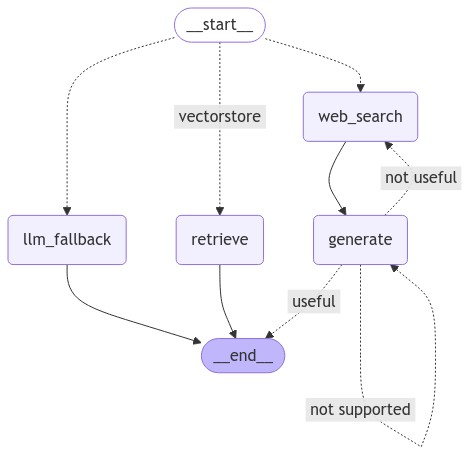

In [15]:
# View
from IPython.display import Image,display

display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
inputs = {
    "question": "Who is Love?"
}

In [18]:
# inputs = {
#     "question": "What are Agents?"
# }


# output=app.invoke(inputs)

In [19]:
# output

In [18]:
config={"configurable":{"thread_id":"1"}}

inputs = {"question": "Who is Love according to thirukural?"}

In [19]:
# Run


for output in app.stream(inputs,config):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
    pprint.pprint("\n---\n")


# # Final generation
# pprint.pprint(value["generation"])

---ROUTE QUESTION---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


---ROUTE QUESTION TO RAG---
---RETRIEVE---


RuntimeError: This event loop is already running

In [1]:
s={'model': 'llama3.1', 'created_at': '2024-11-02T05:27:13.967940736Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'web_search', 'arguments': {'query': 'What is love'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 248395583, 'load_duration': 36640123, 'prompt_eval_count': 259, 'prompt_eval_duration': 9855000, 'eval_count': 19, 'eval_duration': 158883000}

In [4]:
s['message']['tool_calls'][0]

{'function': {'name': 'web_search', 'arguments': {'query': 'What is love'}}}